# Example 2: Goddard problem

## Direct solve

In [1]:
using JuMP, Ipopt, Plots, MINPACK

#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)

# Parameters
Cd = 310.0
Tmax = 3.5
β = 500.0
b = 2.0
N = 200
t0 = 0.0
r0 = 1.0
v0 = 0.0
m0 = 1.0
x0 = [ r0, v0, m0 ]
mf = 0.6

# Variables (some state constraints have been added to ease convergence)
@variables(sys, begin
    0.0 ≤ Δt                      # time step (unknown as tf is free)
    r[1:N+1] ≥ r0                 # r 
    0 ≤ v[1:N+1]                  # v 
    mf ≤ m[1:N+1] ≤ m0            # m
    0.0 ≤ u[1:N+1] ≤ 1.0          # u
end)

# Objective
@objective(sys, Max, r[N+1])

# Boundary constraints 
@constraints(sys, begin
    con_r0, r[1] == r0
    con_v0, v[1] == v0
    con_m0, m[1] == m0
end)

# Dynamics
@NLexpressions(sys, begin
    # D = Cd v^2 exp(-β(r-1))
    D[i = 1:N+1], Cd * v[i]^2 * exp(-β * (r[i] - 1.0))
    # r'= v
    dr[i = 1:N+1], v[i]
    # v' = (Tmax.u-D)/m - 1/r^2
    dv[i = 1:N+1], (Tmax*u[i]-D[i])/m[i] - 1/r[i]^2
    # m' = -b.Tmax.u
    dm[i = 1:N+1], -b*Tmax*u[i]
end)

# Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_dr[i = 1:N], r[i+1] == r[i] + Δt * (dr[i] + dr[i+1])/2.0
    con_dv[i = 1:N], v[i+1] == v[i] + Δt * (dv[i] + dv[i+1])/2.0
    con_dm[i = 1:N], m[i+1] == m[i] + Δt * (dm[i] + dm[i+1])/2.0
end)

(NonlinearConstraintRef{ScalarShape}[r[2] - (r[1] + (Δt * (subexpression[202] + subexpression[203])) / 2.0) = 0, r[3] - (r[2] + (Δt * (subexpression[203] + subexpression[204])) / 2.0) = 0, r[4] - (r[3] + (Δt * (subexpression[204] + subexpression[205])) / 2.0) = 0, r[5] - (r[4] + (Δt * (subexpression[205] + subexpression[206])) / 2.0) = 0, r[6] - (r[5] + (Δt * (subexpression[206] + subexpression[207])) / 2.0) = 0, r[7] - (r[6] + (Δt * (subexpression[207] + subexpression[208])) / 2.0) = 0, r[8] - (r[7] + (Δt * (subexpression[208] + subexpression[209])) / 2.0) = 0, r[9] - (r[8] + (Δt * (subexpression[209] + subexpression[210])) / 2.0) = 0, r[10] - (r[9] + (Δt * (subexpression[210] + subexpression[211])) / 2.0) = 0, r[11] - (r[10] + (Δt * (subexpression[211] + subexpression[212])) / 2.0) = 0  …  r[192] - (r[191] + (Δt * (subexpression[392] + subexpression[393])) / 2.0) = 0, r[193] - (r[192] + (Δt * (subexpression[393] + subexpression[394])) / 2.0) = 0, r[194] - (r[193] + (Δt * (subexpressi

In [2]:
# Solves for the control and state
println("Solving...")
status = optimize!(sys)

if termination_status(sys) == MOI.OPTIMAL
    println("Solution is optimal")

elseif termination_status(sys) == MOI.LOCALLY_SOLVED
    println("Local solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("The model was not solved correctly.")
end
println("Objective value = ", objective_value(sys), "\n")

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
rr = value.(r)
vv = value.(v)
mm = value.(m)
uu = value.(u)
Δtt = value.(Δt)
pr = -[ dual(con_dr[i]) for i = 1:N ]
pv = -[ dual(con_dv[i]) for i = 1:N ]
pm = -[ dual(con_dm[i]) for i = 1:N ];

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3803
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11400

Total number of variables............................:      805
                     variables with only lower bounds:      403
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of in

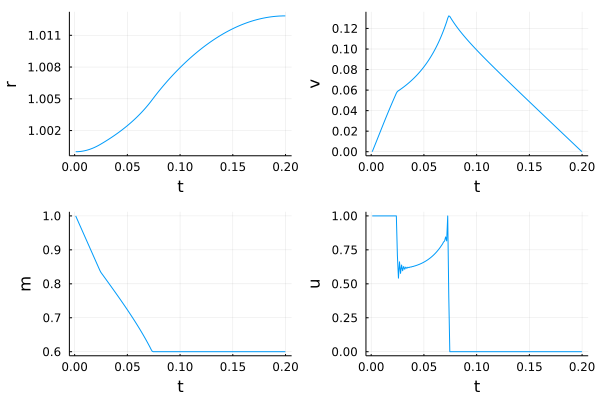

In [20]:
# Plots: state and control
t = (1:N+1)*Δtt
r_plot = plot(t, rr, xlabel = "t", ylabel = "r", legend = false, fmt = :png)
v_plot = plot(t, vv, xlabel = "t", ylabel = "v", legend = false, fmt = :png)
m_plot = plot(t, mm, xlabel = "t", ylabel = "m", legend = false, fmt = :png)
u_plot = plot(t, uu, xlabel = "t", ylabel = "u", legend = false, fmt = :png)
display(plot(r_plot, v_plot, m_plot, u_plot, layout = (2,2)))

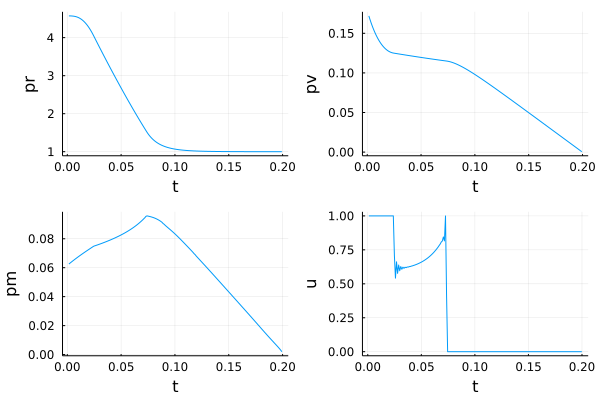

In [21]:
# Plots: adjoint state
tt = (t[1:end-1] + t[2:end])/2.0
pr_plot = plot(tt, pr,xlabel = "t", ylabel = "pr", legend = false, fmt = :png)
pv_plot = plot(tt, pv,xlabel = "t", ylabel = "pv", legend = false, fmt = :png)
pm_plot = plot(tt, pm,xlabel = "t", ylabel = "pm", legend = false, fmt = :png)
display(plot(pr_plot, pv_plot, pm_plot, u_plot, layout = (2,2)))

## Indirect solve

In [22]:
include("flow.jl")

# Dynamics
function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r-1.0))
    F = [ v, -D/m-1.0/r^2, 0.0 ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0.0, Tmax/m, -b*Tmax ]
    return F
end

# Computation of singular control of order 1
H0 = (x, p) -> p' * F0(x)
H1 = (x, p) -> p' * F1(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us = (x, p) -> -H001(x, p)/H101(x, p)

# Hamiltonians (regular, singular) and associated flows
H = (x, p, u) -> H0(x, p) + u*H1(x, p)
Hr = (x, p) -> H(x, p, 1.0)
Hs = (x, p) -> H(x, p, us(x, p))

f0 = Flow(H0)
fr = Flow(Hr)
fs = Flow(Hs);

In [23]:
# Shooting function
function shoot(p0, t1, t2, tf) # B+ S B0 structure

    x1, p1 = fr(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    xf, pf = f0(t2, x2, p2, tf)
    s = zeros(eltype(p0), 6)
    s[1:2] = pf[1:2] - [ 1.0, 0.0 ]
    s[3] = xf[3] - mf # supposed to be active
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = H0(xf, pf) # free tf

    return s

end

shoot (generic function with 1 method)

In [24]:
# Initialisations
p0 = [ pr[1], pv[1], pm[1] ] # rough init from direct solve
t1 = 0.025
t2 = 0.075
tf = 0.2
ξ = [ p0 ; t1 ; t2 ; tf ]

# Solve
foo   = ξ -> shoot(ξ[1:3], ξ[4], ξ[5], ξ[6])
jfoo  = ξ -> ForwardDiff.jacobian(foo, ξ)
foo!  = (s, ξ) -> ( s[:] = foo(ξ); nothing )
jfoo! = (js, ξ) -> ( js[:] = jfoo(ξ); nothing )

println("Initial value of shooting:\n", foo(ξ), "\n\n")

#nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)
nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:3]
    t1 = nl_sol.x[4]
    t2 = nl_sol.x[5]
    tf = nl_sol.x[6];
else
    error("Not converged")
end

Initial value of shooting:
[-0.19982971533167837, 0.02441392402210616, -0.022389952963994486, -0.015173241580837757, 0.24537555893666, -0.011825017300795614]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.453756e-01     0.000000e+00         0.265114
     2     9.803951e-02     4.876316e-03         1.105653
     3     3.033454e-02     1.267063e-03         0.143439
     4     3.373697e-03     1.148314e-03         0.157756
     5     6.522058e-04     2.150145e-07         0.143120
     6     9.362420e-05     1.024977e-08         0.143138
     7     9.212047e-06     6.176861e-10         0.143706
     8     1.119524e-06     4.689986e-12         0.156659
     9     1.479188e-07     5.503654e-14         0.144144
    10     3.347347e-08     2.940269e-15         0.143555
    11     8.838143e-10     1.283077e-16         0.157260
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [4.5

0.19885626211396584

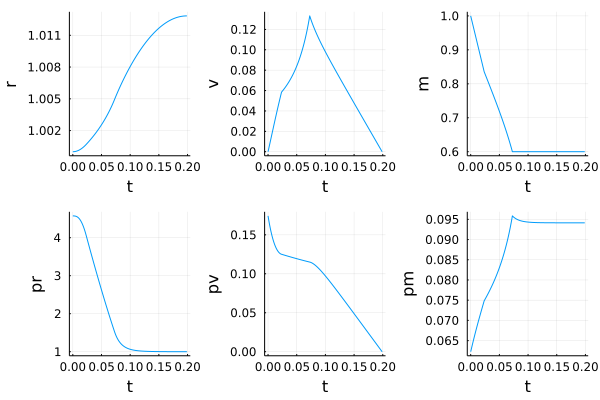

In [25]:
# Plots
ode_sol = fr((t0, t1), x0, p0)
tt0 = ode_sol.t
xx0 = ode_sol[1:3, :]
pp0 = ode_sol[4:6, :]

ode_sol = fs((t1, t2), xx0[:, end], pp0[:, end])
tt1 = ode_sol.t
xx1 = ode_sol[1:3, :]
pp1 = ode_sol[4:6, :]

ode_sol = f0((t2, tf), xx1[:, end], pp1[:, end])
tt2 = ode_sol.t
xx2 = ode_sol[1:3, :]
pp2 = ode_sol[4:6, :]

ts  = [ tt0 ; tt1 ; tt2 ]
rs  = [ xx0[1, :] ; xx1[1, :] ; xx2[1, :] ]
vs  = [ xx0[2, :] ; xx1[2, :] ; xx2[2, :] ]
ms  = [ xx0[3, :] ; xx1[3, :] ; xx2[3, :] ]
prs = [ pp0[1, :] ; pp1[1, :] ; pp2[1, :] ]
pvs = [ pp0[2, :] ; pp1[2, :] ; pp2[2, :] ]
pms = [ pp0[3, :] ; pp1[3, :] ; pp2[3, :] ]

r_plot  = plot(ts, rs, xlabel = "t", ylabel = "r", legend = false, fmt = :png)
v_plot  = plot(ts, vs, xlabel = "t", ylabel = "v", legend = false, fmt = :png)
m_plot  = plot(ts, ms, xlabel = "t", ylabel = "m", legend = false, fmt = :png)
pr_plot = plot(ts, prs, xlabel = "t", ylabel = "pr", legend = false, fmt = :png)
pv_plot = plot(ts, pvs, xlabel = "t", ylabel = "pv", legend = false, fmt = :png)
pm_plot = plot(ts, pms, xlabel = "t", ylabel = "pm", legend = false, fmt = :png)
display(plot(r_plot, v_plot, m_plot, pr_plot, pv_plot, pm_plot, layout = (2,3)))